In [32]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [33]:
from astropy.utils.data import download_file

p = download_file('https://github.com/rodluger/trappist1/raw/master/output/nPLDTrappist.fits')
f = fits.getdata(p)

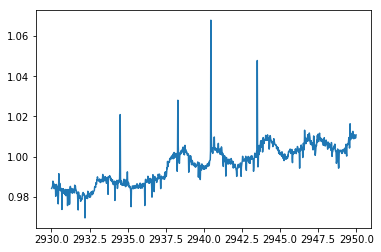

In [34]:
time = f['TIME']
flux = f['FLUX']/np.nanmedian(f['FLUX'])

# Toss low fluxes, high flues
condition = ((flux > 0.95) & (flux < 1.2) & (time > 2930) & (time < 2950))

plt.plot(time[condition], flux[condition])

In [35]:
import sys
sys.path.insert(0, '../libra')

In [36]:
from libra import trappist1

In [37]:
import batman

In [38]:
bjd_offset = 2454833.0

model_fluxes = []
for planet in list('bcdefgh'):
    params = trappist1(planet)
    m = batman.TransitModel(params, time + bjd_offset)
    f = m.light_curve(params)
    model_fluxes.append(f)
    
model_fluxes = np.array(model_fluxes)

In [39]:
oot = np.all(model_fluxes == 1, axis=0)
condition &= oot
in_transit = np.logical_not(oot)

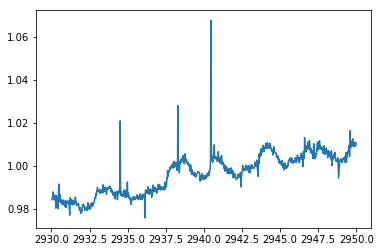

In [40]:
plt.figure()
plt.plot(time[condition], flux[condition])
plt.scatter(time[condition & in_transit], flux[condition & in_transit], color='r')

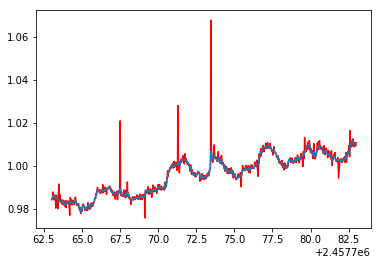

In [41]:
from scipy.ndimage import median_filter

plt.figure()

filtered_time = time[condition] + bjd_offset
filtered_flux = median_filter(flux[condition], (5,))

plt.plot(time[condition] + bjd_offset, flux[condition], 'r')
plt.plot(filtered_time, filtered_flux)

In [42]:
p = np.polyfit(filtered_time, filtered_flux, 2)

filtered_detrended_flux = 1 + filtered_flux - np.polyval(p, filtered_time)

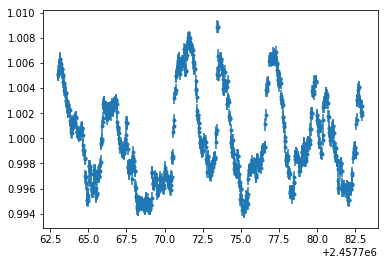

In [43]:
fake_err = np.ones_like(filtered_detrended_flux) * 0.0005
plt.figure()
plt.errorbar(filtered_time, filtered_detrended_flux, fake_err, fmt='.')

np.savetxt('trappist_rotation.txt', np.vstack([filtered_time, filtered_detrended_flux, fake_err]).T)

In [44]:
def quadratic_to_nonlinear(u1, u2):
    """LD params: """
    a1 = a3 = 0
    a2 = u1 + 2*u2
    a4 = -u2
    return (a1, a2, a3, a4)

quadratic_to_nonlinear(1.00, -0.04) # Luger 2017

(0, 0.92, 0, 0.04)